In [4]:
import pandas as pd
import copy

# Torch & Tensorflow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tensorflow as tf

# Visualization
from torchviz import make_dot
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [5]:
#####Configuration#####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
###### desired size of the output image######
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)  # use small size if no gpu

loader = torchvision.transforms.Compose([
    torchvision.transforms.Resize(imsize),  # scale imported image
    torchvision.transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)

    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [7]:
########Plot tensor images as PIL image####
unloader = torchvision.transforms.ToPILImage() 

def imshow_tensor(tensor, ax=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension

    image = unloader(image)
    if ax:
        ax.imshow(image)
    else:
        plt.imshow(image)

In [8]:
#####Functions from Part 2 - loss functions#####
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    # Get the size of tensor
    # a: batch size
    # b: number of feature maps
    # c, d: the dimension of a feature map
    a, b, c, d = input.size() 
    
    # Reshape the feature 
    features = input.view(a * b, c * d)

    # Multiplication
    G = torch.mm(features, features.t())  
    
    # Normalize 
    G_norm = G.div(a * b * c * d)
    return G_norm

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
######Part 3 - modeling#####
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [10]:
#######Create a sequential model for style transfer#####
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for n_child, layer in enumerate(cnn.children()):
#         print()
#         print(f"n_child: {n_child}")
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)
#         print(f'Name: {name}')
        if name in content_layers:
#             print(f'Add content loss {i}')
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
#             print(f'Add style loss {i}')
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [11]:
###########Load images###########
d_path = {}
d_path['content'] = tf.keras.utils.get_file('turtle.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg')
d_path['style'] = tf.keras.utils.get_file('kandinsky.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_img = image_loader(d_path['style'])[:, :, :, :170]
content_img = image_loader(d_path['content'])[:, :, :, :170]
input_img = content_img.clone()

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [12]:
########Modeling###############
# Obtain the model for style transfer
# with warnings.catch_warnings():
warnings.filterwarnings("ignore")
cnn = torchvision.models.vgg19(pretrained=True).features.to(device).eval()
model, style_losses, content_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, style_img, content_img)


In [13]:
######Executing a neural transfer#########
####Gradient Decent########
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])
    return optimizer

optimizer = get_input_optimizer(input_img)

In [14]:
# Parameters
num_steps = 10
style_weight=5000
content_weight=1
input_img = content_img[:, :, :, :170].clone()
d_images = {}

print('Building the style transfer model..')
model, style_losses, content_losses = get_style_model_and_losses(cnn,
    cnn_normalization_mean, cnn_normalization_std, style_img, content_img)
optimizer = get_input_optimizer(input_img)

# Execution
run = [0]
while run[0] <= num_steps:

    def closure():
        # correct the values of updated input image
        input_img.data.clamp_(0, 1)

        optimizer.zero_grad()
        model(input_img)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        content_score *= content_weight

        loss = style_score + content_score
        loss.backward()

        run[0] += 1
        if run[0] % 2 == 0:
            print("run {}:".format(run))
            print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                style_score.item(), content_score.item()))
            input_img.data.clamp_(0, 1)
            d_images[run[0]] = input_img
            print()

        return style_score + content_score

    optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

Building the style transfer model..
run [2]:
Style Loss : 224.513367 Content Loss: 0.000001

run [4]:
Style Loss : 184.947769 Content Loss: 16.262529

run [6]:
Style Loss : 83.247238 Content Loss: 8.902849

run [8]:
Style Loss : 52.988003 Content Loss: 13.945158

run [10]:
Style Loss : 34.382072 Content Loss: 18.180187

run [12]:
Style Loss : 25.200127 Content Loss: 17.484568

run [14]:
Style Loss : 18.582045 Content Loss: 18.929888

run [16]:
Style Loss : 14.954358 Content Loss: 18.410954

run [18]:
Style Loss : 11.679198 Content Loss: 19.008219

run [20]:
Style Loss : 9.478721 Content Loss: 19.874796



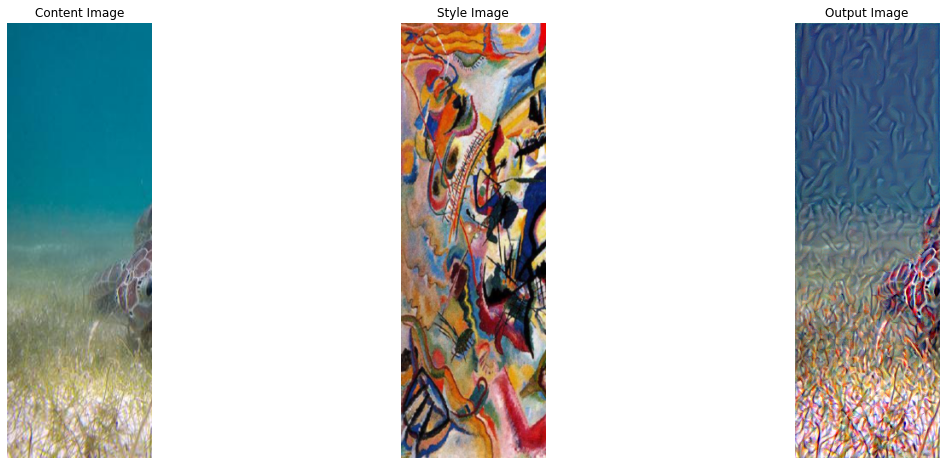

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
d_img = {"Content": content_img,
         "Style": style_img,
         "Output": input_img}
for i, key in enumerate(d_img.keys()):
    imshow_tensor(d_img[key], ax=axes[i])
    axes[i].set_title(f"{key} Image")
    axes[i].axis('off')

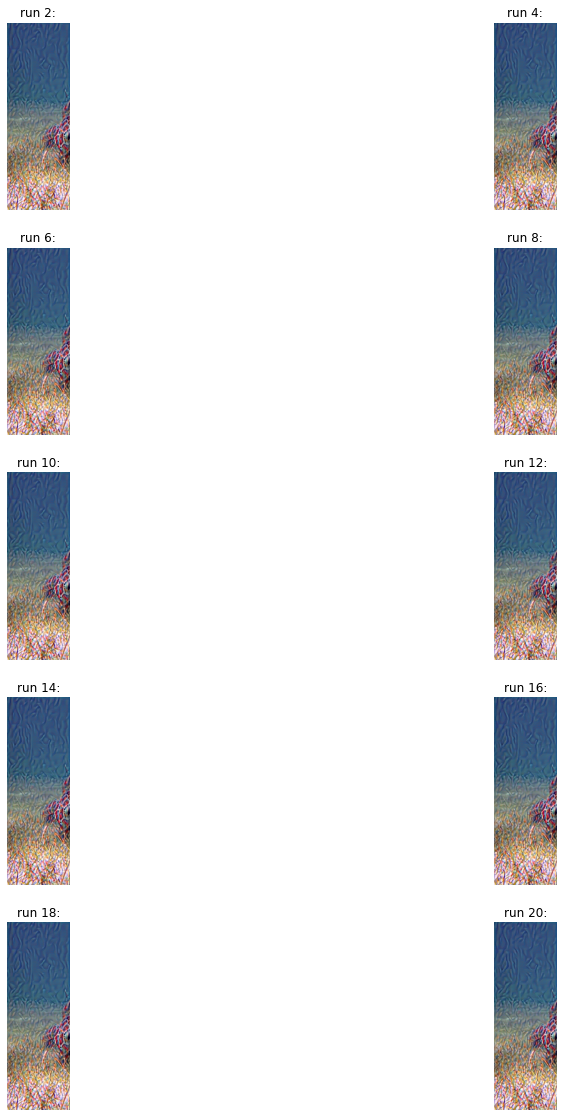

In [20]:
#####Visualize the process of style transfer#######
fig, axes = plt.subplots(int(len(d_images)/2), 2, figsize=(16, 20))
for i, key in enumerate(d_images.keys()):
    imshow_tensor(d_images[key], ax=axes[i//2][i%2])
    axes[i//2][i%2].set_title("run {}:".format(key))
    axes[i//2][i%2].axis('off')